In [1]:
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
import os
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from tqdm import tqdm
sns.set_palette('Dark2')


In [2]:
sns.set_style({'axes.axisbelow': True, 'axes.edgecolor': '.15', 'axes.facecolor': 'white',
               'axes.grid': True, 'axes.labelcolor': '.15', 'axes.linewidth': 0.5, 
               'figure.facecolor': 'white',  'grid.color': '.15',
               'grid.linestyle': '-', 'grid.alpha': .1, 'image.cmap': 'Greys', 
               'legend.frameon': False, 'legend.numpoints': 1, 'legend.scatterpoints': 1,
               'lines.solid_capstyle': 'round', 'axes.spines.right': False, 'axes.spines.top': False,  
               'text.color': '.15',  'xtick.top': False, 'ytick.right': False, 'xtick.color': '.15',
               'xtick.direction': 'out', 'xtick.major.size': 3, 'xtick.minor.size': 1.5,
               'ytick.color': '.15', 'ytick.direction': 'out', 'ytick.major.size': 3,'ytick.minor.size': 1.5})
sns.set_context('paper')

#http://phyletica.org/matplotlib-fonts/
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [3]:
from snapanalysis.config import OUTPUT_DIRECTORY as OUTPUT_DIRECTORY_MAIN
OUTPUT_DIRECTORY = os.path.join(OUTPUT_DIRECTORY_MAIN, 'scatterplots')
if not os.path.isdir(OUTPUT_DIRECTORY):
    os.makedirs(OUTPUT_DIRECTORY)

In [4]:
from snapanalysis.models.enrichment.generate import OUTPUT_FILE as ENRICHMENT_FILE
from snapanalysis.models.enrichment.generate import MATRIX_COLUMN_FORWARD, MATRIX_COLUMN_REVERSE
MATRIX_COLUMN_FORWARD

'Ratio H/L normalized (log2) (adjusted, imputed, forward)'

In [5]:
with pd.HDFStore(ENRICHMENT_FILE, 'r') as store:
    data = store['enrichment_data']

In [6]:
from snapanalysis.external.complexes.curated import OUTPUT_FILE as COMPLEXES_FILE

with pd.HDFStore(COMPLEXES_FILE, 'r') as store:
    curated_complexes = store['curated_complexes']

In [7]:
curated_complexes.head()

,Complex,Gene label,Member identifier,Source
6,40S Ribosomal subunit,FAU,FAU,"uniprot_search:""40S Ribosomal"""
7,40S Ribosomal subunit,RPS10/RPS10-NUDT3,RPS10,"uniprot_search:""40S Ribosomal"""
8,40S Ribosomal subunit,RPS11,RPS11,"uniprot_search:""40S Ribosomal"""
9,40S Ribosomal subunit,RPS12,RPS12,"uniprot_search:""40S Ribosomal"""
10,40S Ribosomal subunit,RPS13,RPS13,"uniprot_search:""40S Ribosomal"""


In [8]:
COLUMN_X = MATRIX_COLUMN_FORWARD
COLUMN_Y = MATRIX_COLUMN_REVERSE


In [9]:
WIDTH = HEIGHT =  2.6 # in

In [10]:
import parameters

import importlib
importlib.reload(parameters)

<module 'parameters' from '/notebooks/scatterplots/parameters.py'>

In [11]:
COLOUR_BACKGROUND = parameters.COLOUR_BACKGROUND

In [12]:
import matplotlib.ticker as ticker

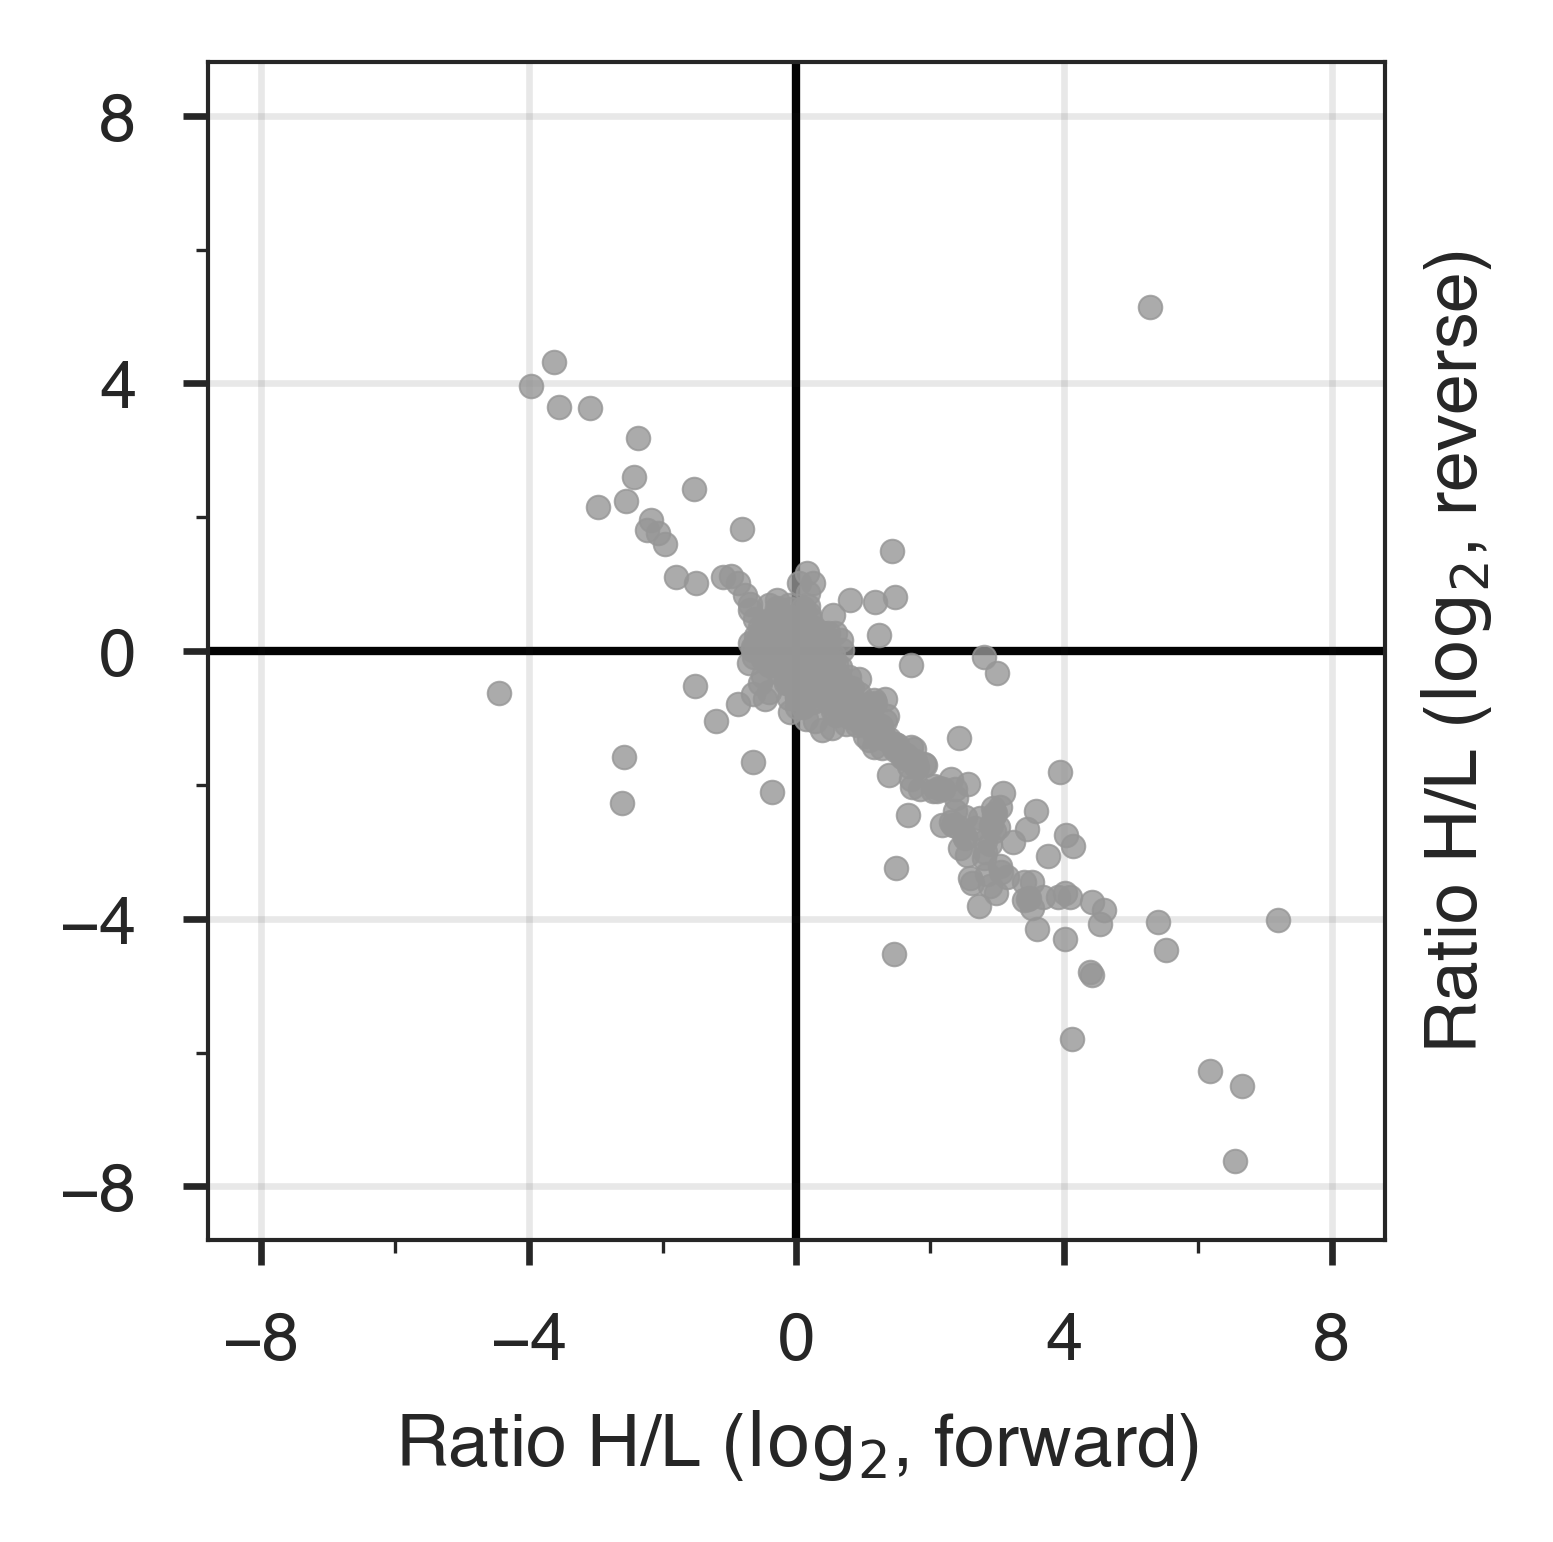

In [13]:
# Exemplary pull-down no highlighting

pulldown = 'H41'

subdata = data.loc(axis=0)[:, pulldown].dropna(subset=[COLUMN_X, COLUMN_Y])
subdata = subdata[subdata['Imputation type'].isnull()]

subdata_background = subdata
scatter_kws = dict(s=8)

fig = plt.figure(figsize=(WIDTH, HEIGHT), dpi=300)
ax = plt.gca()
ax.axhline(0, color='k', linestyle='-', linewidth=1.0, zorder=0)
ax.axvline(0, color='k', linestyle='-', linewidth=1.0, zorder=0)

ax.scatter(subdata_background[COLUMN_X], subdata_background[COLUMN_Y], 
           rasterized=True, color=COLOUR_BACKGROUND, alpha=.8,
           zorder=1, **scatter_kws)


xlim = ax.get_xlim()
ylim = ax.get_ylim()


absmax = parameters.LIMITS_INTEGER * 1.1


ax.set_ylim(-absmax, absmax)
ax.set_xlim(-absmax, absmax)

ax.xaxis.set_major_locator(ticker.MultipleLocator(parameters.MAJOR_TICKS))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(parameters.MINOR_TICKS))
ax.yaxis.set_major_locator(ticker.MultipleLocator(parameters.MAJOR_TICKS))
ax.yaxis.set_minor_locator(ticker.MultipleLocator(parameters.MINOR_TICKS))
ax.yaxis.set_label_position("right")

ax.grid(True)
ax.spines['top'].set_visible(True)
ax.spines['right'].set_visible(True)
ax.set_aspect('equal')

ax.set_xlabel('Ratio H/L ($\log_2$, forward)')
ax.set_ylabel('Ratio H/L ($\log_2$, reverse)')

plt.savefig(os.path.join(OUTPUT_DIRECTORY, f'scatter-{pulldown}.pdf'), bbox_inches='tight')

In [14]:
COLOUR_BACKGROUND

'#969696'

In [15]:
from matplotlib.colors import Normalize, LinearSegmentedColormap
from adjustText import adjust_text

# With a bit darker gray
modified_rdbu_r = LinearSegmentedColormap.from_list('DarkerRdBu_r', [
    '#0571b0', 
    # This is the gray color, it is '#f7f7f7' in colorbrewer, we make it a bit darker:
    COLOUR_BACKGROUND, 
    '#ca0020',
])

def plot_examplary(pulldown, dpi=500):
    # Exemplary pull-down - alternative plot
    highlights = [
        'KDM2B',
        'MECP2 (2)',
        'ORC2',
        'SLF1',
        'UHRF1',
        #'CBX3', 
        'CBX5',
        'EZH2',
        'SUZ12',
        'SMARCC1',
        'PBRM1',
        'PHF8 (1)',
        'TAF3',
        'BRD4',
        'BRD3',
        'INO80B',
        'SRCAP'
    ]

    norm = Normalize(-4, 4)

    subdata = data.loc(axis=0)[:, pulldown].dropna(subset=[COLUMN_X, COLUMN_Y])
    subdata = subdata.reset_index(level='Pull-Down ID')
    
    # Only non-imputed values or proteins with highlight
    mask = subdata['Imputation type'].isnull()
    mask |= [ix in highlights for ix in subdata.index]
    
    subdata = subdata[mask]
    subdata = subdata.copy()

    subdata['c'] = 0.5 * (subdata[COLUMN_X] + (-subdata[COLUMN_Y]))
    
    imputed_highlights = ~subdata.loc[highlights, 'Imputation type'].isnull()
    imputed_highlights = imputed_highlights[imputed_highlights].index
    
    if len(imputed_highlights) > 0:
        print("Warning, the following highlighted proteins are imputed: ", imputed_highlights)
    
    subdata_background = subdata.loc[subdata.index.difference(highlights)].sort_values(by='c')
    subdata_foreground = subdata.loc[highlights].sort_values(by='c')

    fig = plt.figure(figsize=(WIDTH, HEIGHT), dpi=dpi)
    ax = plt.gca()
    ax.axhline(0, color='k', linestyle='-', linewidth=1.0, zorder=0)
    ax.axvline(0, color='k', linestyle='-', linewidth=1.0, zorder=0)
    
    cmap = modified_rdbu_r

    ax.scatter(subdata_background[COLUMN_X], subdata_background[COLUMN_Y], 
               rasterized=True,
               c=subdata_background['c'],
               cmap=cmap,
               norm=norm,
               alpha=.8,
#                edgecolor='none',
               edgecolor='white',
               zorder=1, s=8)

    texts = []
    for ix, row in subdata_foreground.iterrows():
        edgecolor = 'black'
        linestyle = '--' if ix in imputed_highlights else '-'
        suffix = '*' if ix in imputed_highlights else ''
        ax.scatter([row[COLUMN_X]], [row[COLUMN_Y]], 
                   rasterized=False,
                   c=[row['c']],
                   cmap=cmap,
                   norm=norm,
                   edgecolor=edgecolor,
                   linewidth=0.5,
                   linestyle='--' if ix in imputed_highlights else '-',
                   zorder=2, s=12)
        
        text = ax.text(row[COLUMN_X], row[COLUMN_Y], ix + suffix, 
                       fontsize=5)
        texts.append(text)


    xlim = ax.get_xlim()
    ylim = ax.get_ylim()

    adjust_text(texts, subdata[COLUMN_X], subdata[COLUMN_Y],
                force_points=(0.2, 0.2),
                force_text=(0.4, 0.4),
                arrowprops=dict(arrowstyle='-', color='black', linewidth=0.5))

    absmax = parameters.LIMITS_INTEGER * 1.1


    ax.set_ylim(-absmax, absmax)
    ax.set_xlim(-absmax, absmax)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(parameters.MAJOR_TICKS))
    ax.xaxis.set_minor_locator(ticker.MultipleLocator(parameters.MINOR_TICKS))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(parameters.MAJOR_TICKS))
    ax.yaxis.set_minor_locator(ticker.MultipleLocator(parameters.MINOR_TICKS))
    ax.yaxis.set_label_position("right")

    ax.grid(True)
    ax.spines['top'].set_visible(True)
    ax.spines['right'].set_visible(True)
    ax.set_aspect('equal')

    ax.set_xlabel('Ratio H/L ($\log_2$, forward)')
    ax.set_ylabel('Ratio H/L ($\log_2$, reverse)')


    

Warning, the following highlighted proteins are imputed:  Index(['UHRF1'], dtype='object', name='Gene label')


/usr/local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:56: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  return getattr(obj, method)(*args, **kwds)


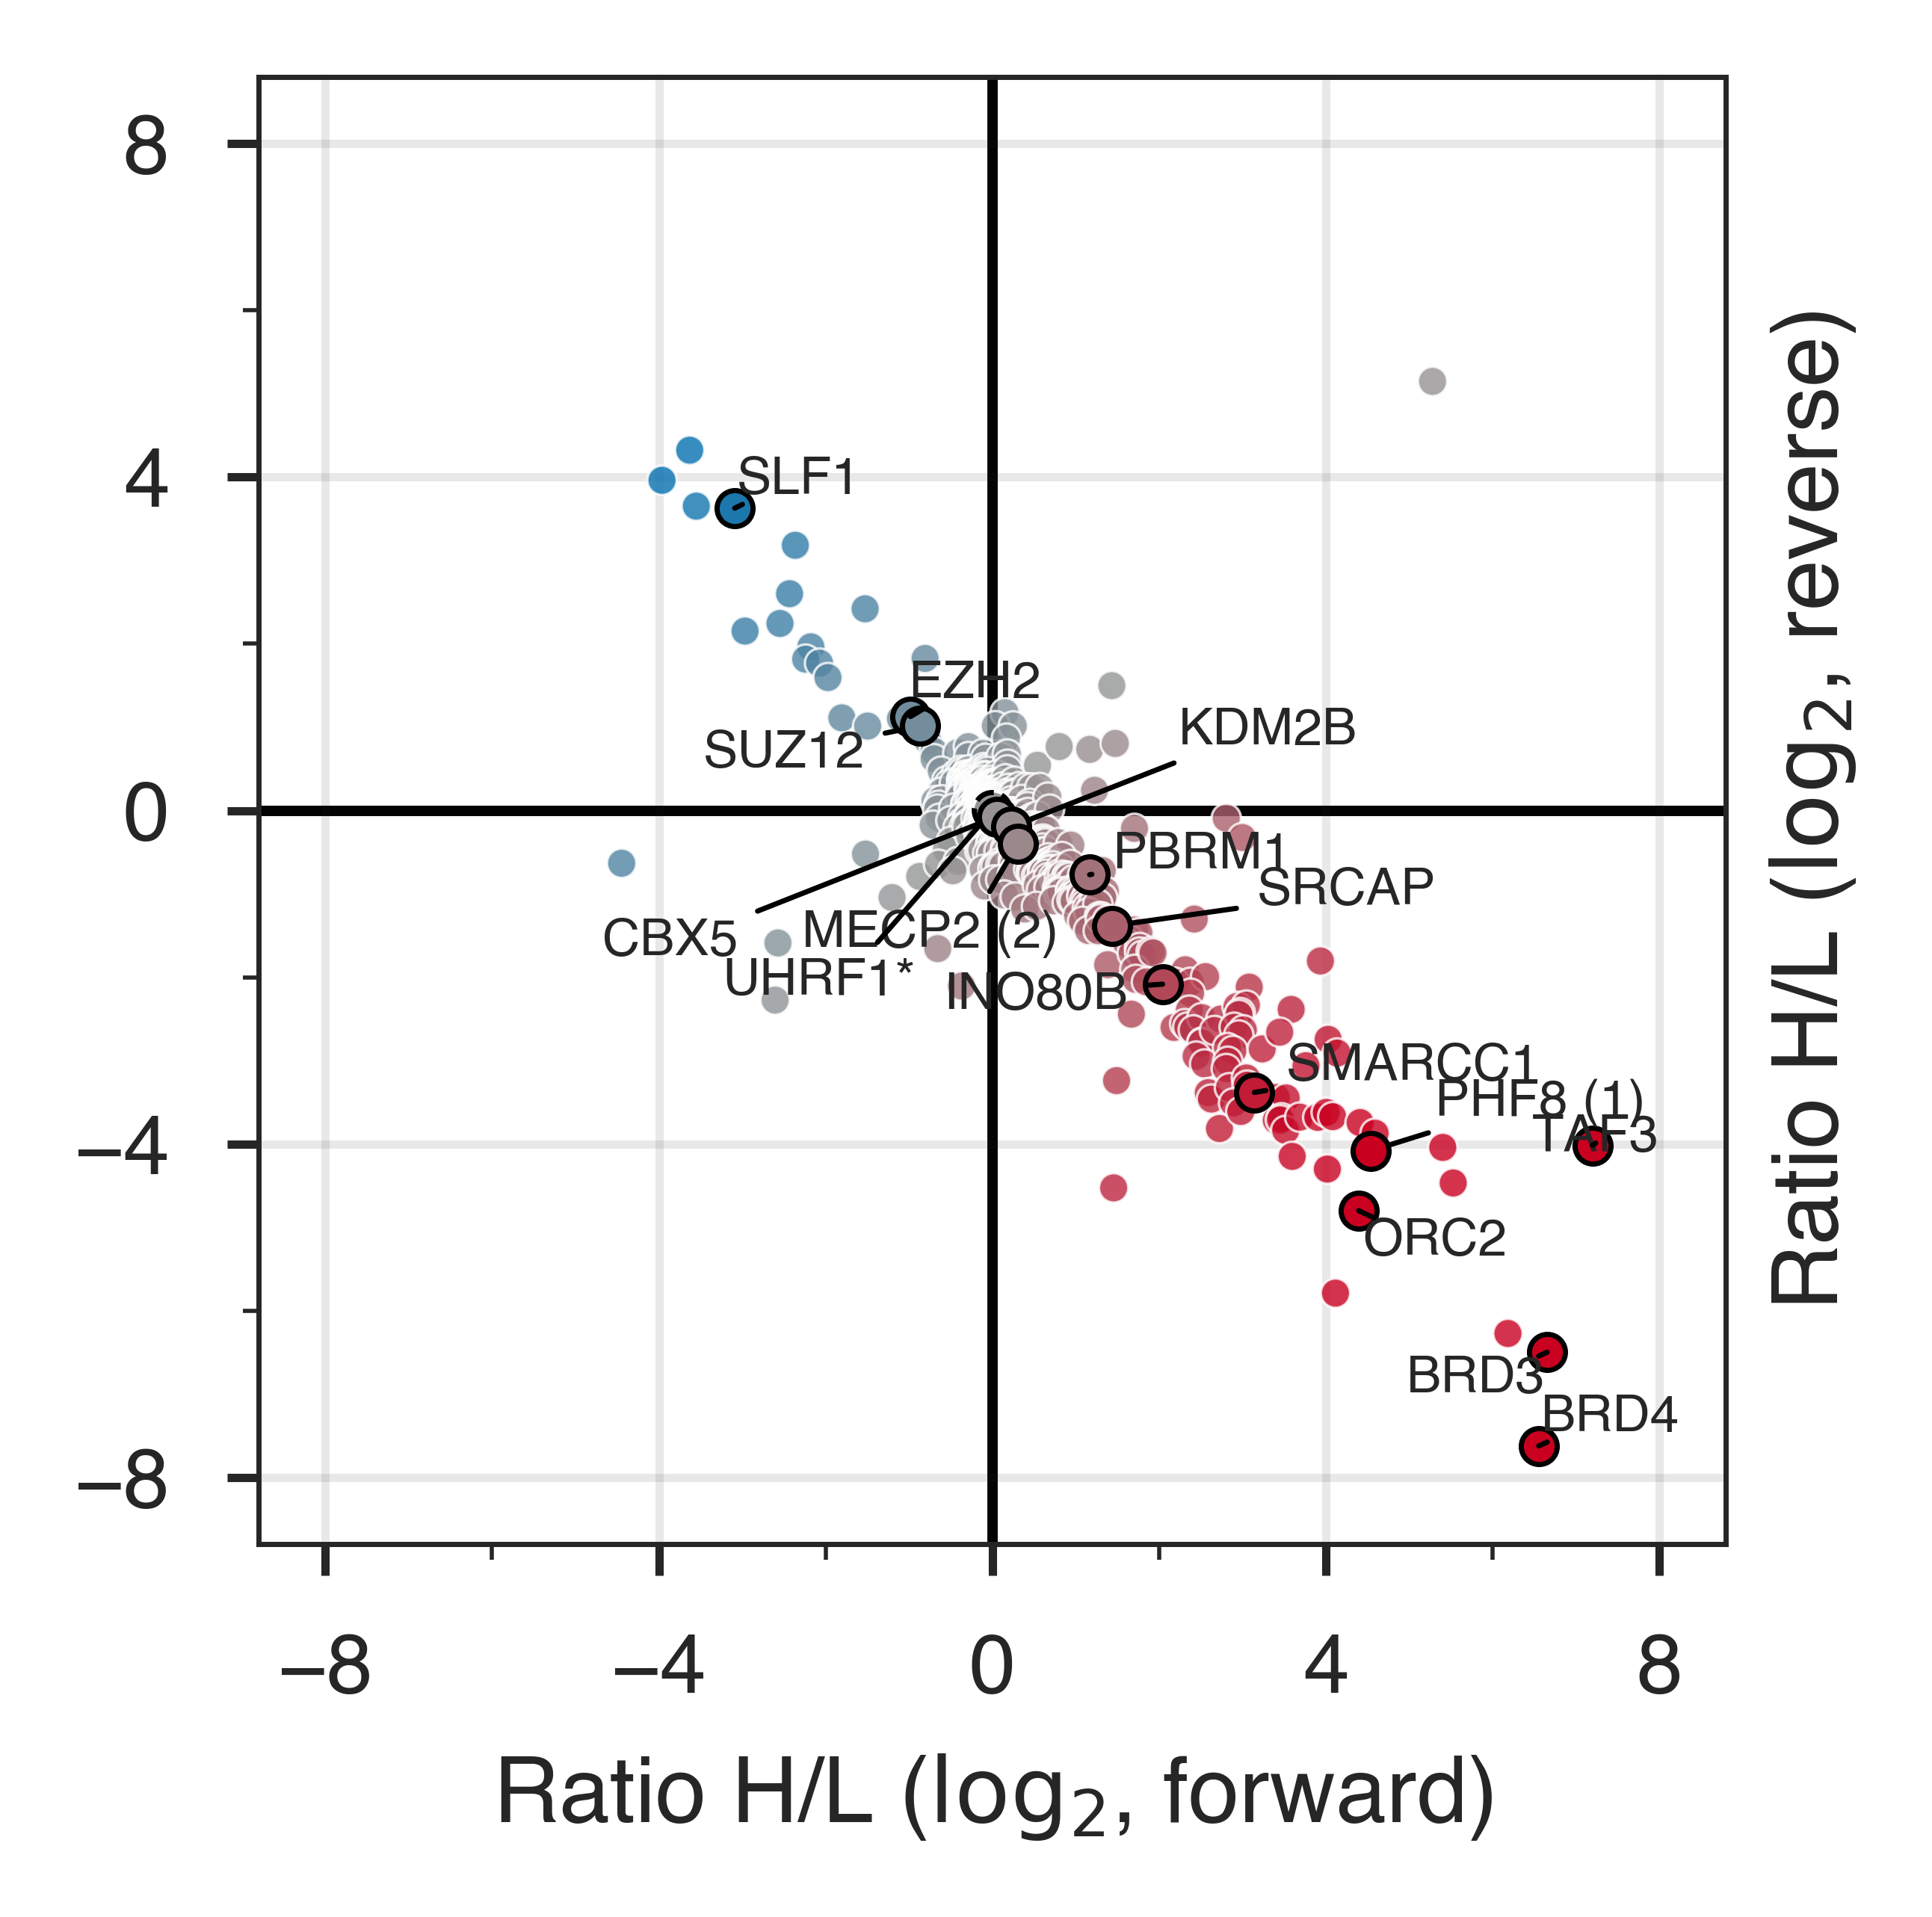

In [16]:
_pd = 'H41'
plot_examplary(_pd, dpi=500)
plt.savefig(os.path.join(OUTPUT_DIRECTORY, f'scatter-{_pd}-RdBu_r.pdf'), 
            dpi=500,
            bbox_inches='tight')

In [17]:
%pdb on

Automatic pdb calling has been turned ON


Warning, the following highlighted proteins are imputed:  Index(['UHRF1', 'CBX5'], dtype='object', name='Gene label')


/usr/local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:56: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  return getattr(obj, method)(*args, **kwds)


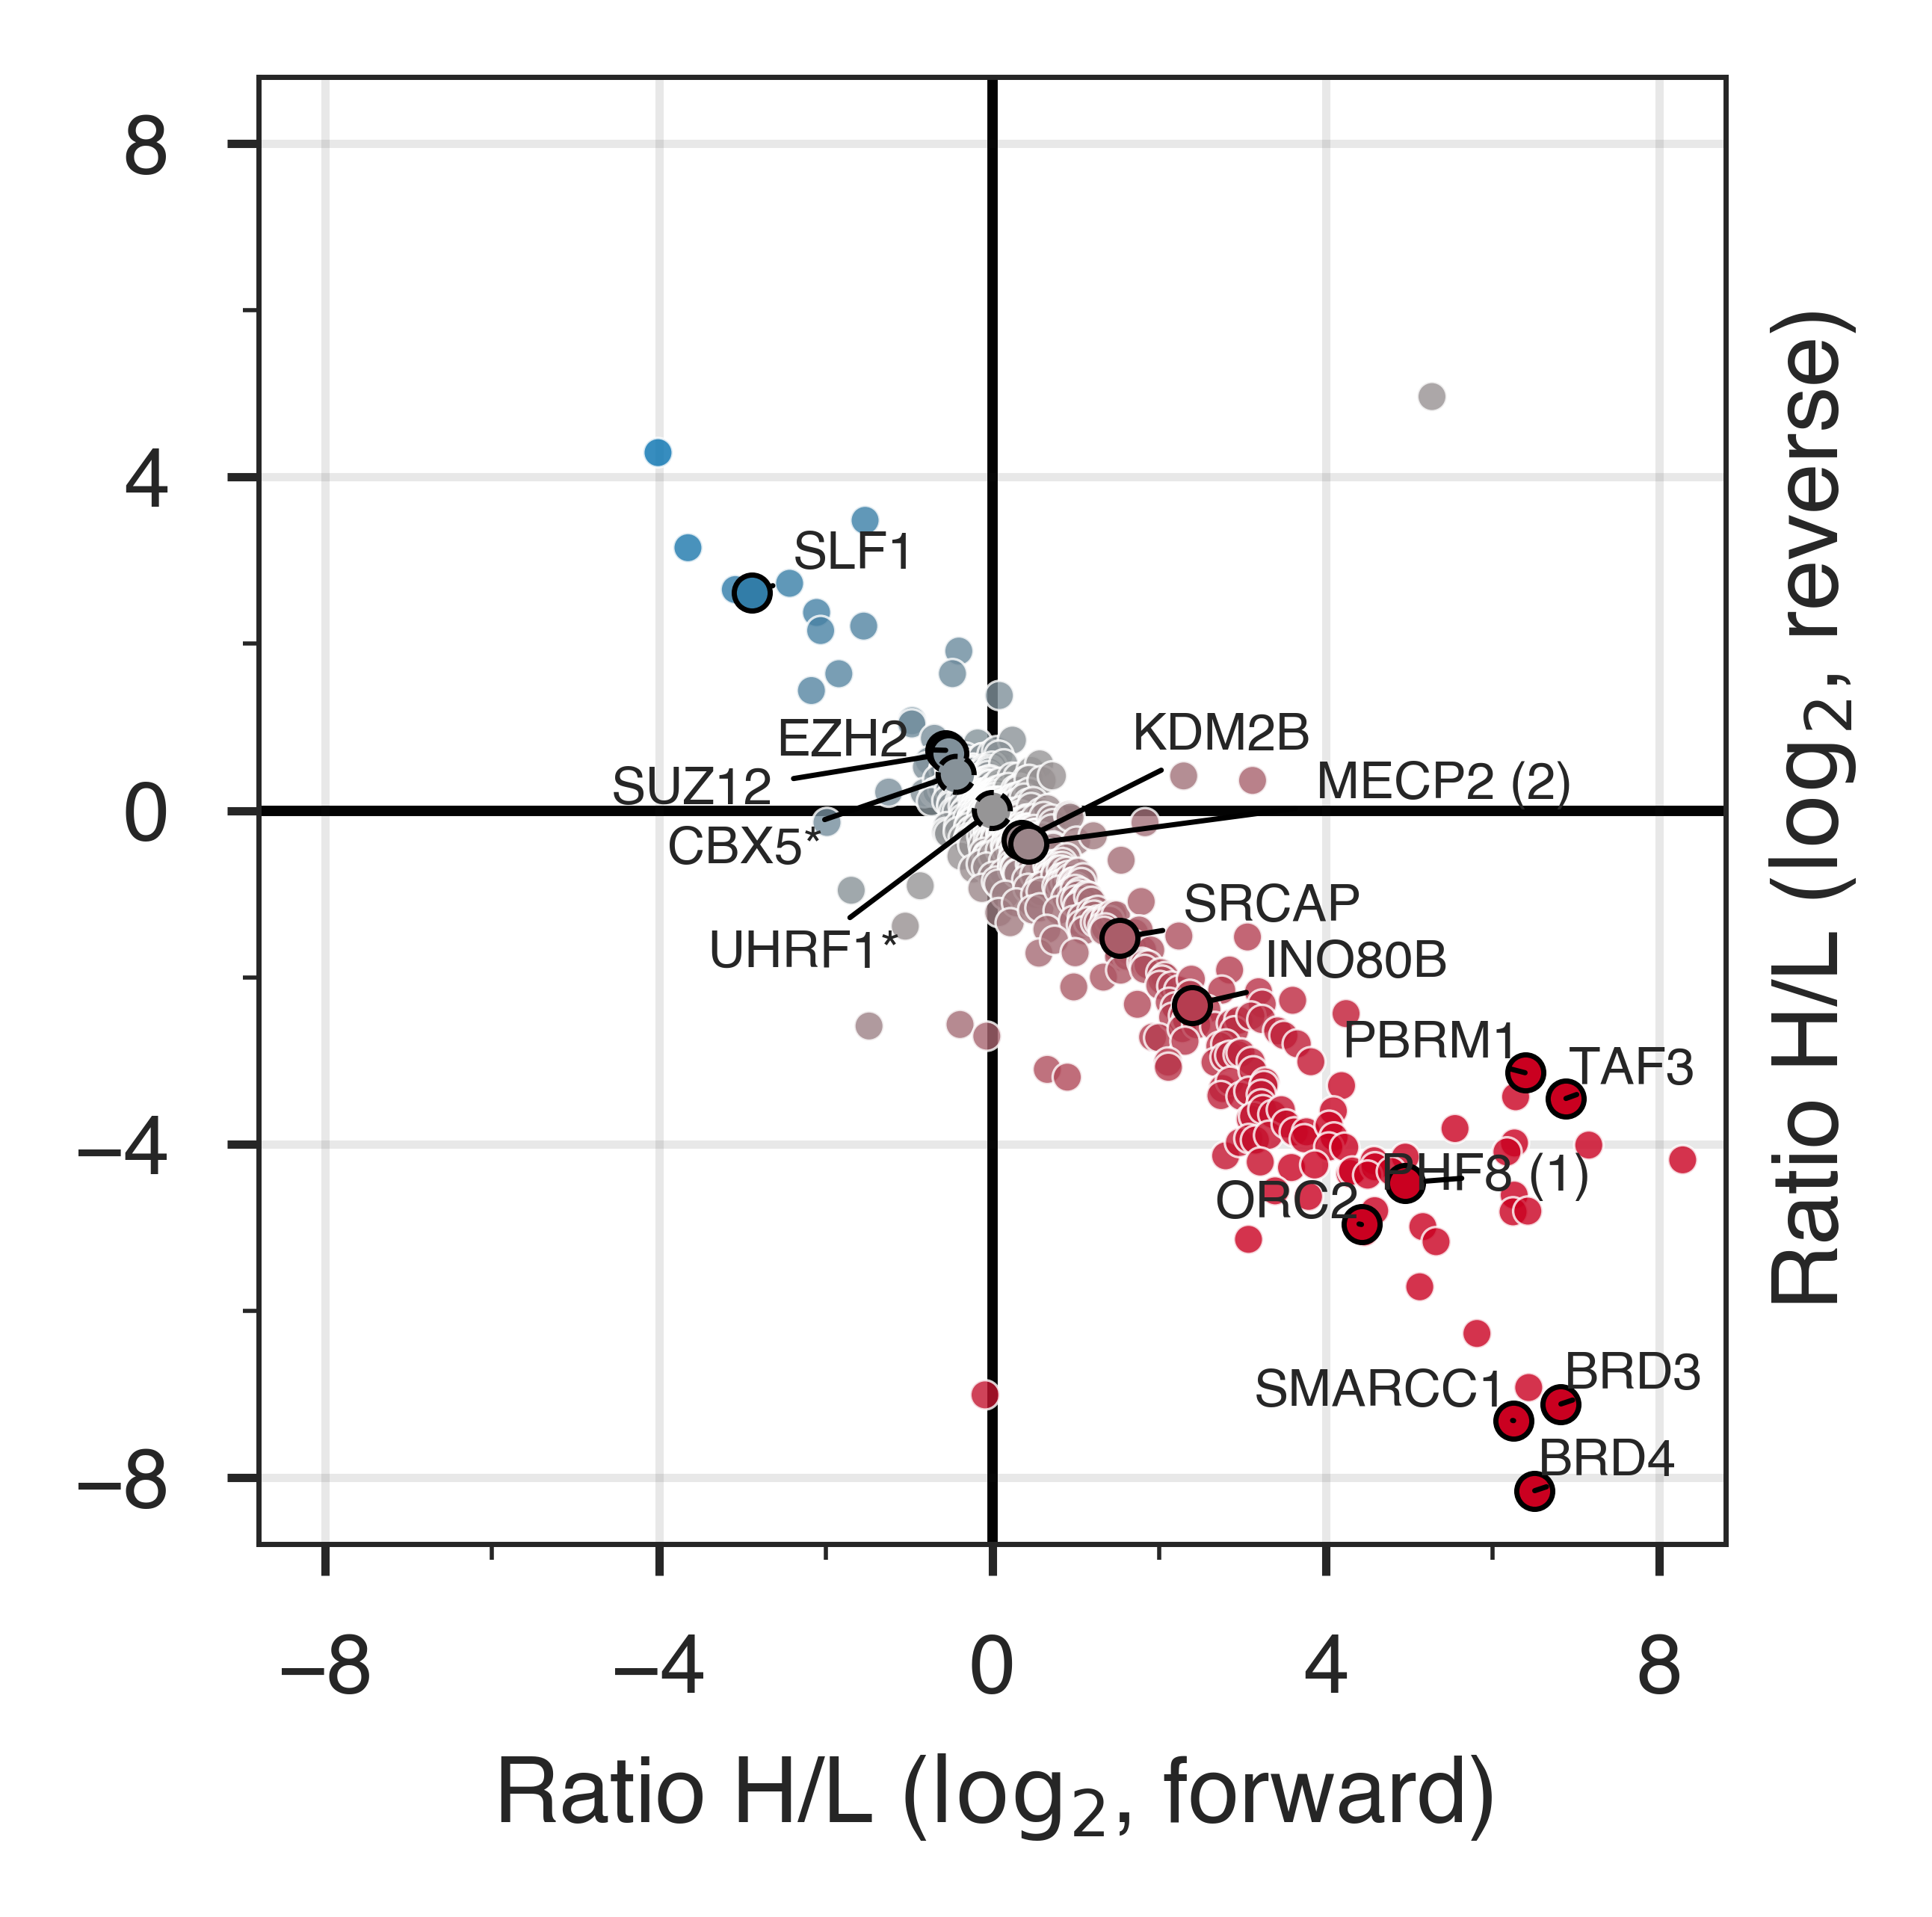

In [18]:
_pd = 'H42'
plot_examplary(_pd, dpi=500)
plt.savefig(os.path.join(OUTPUT_DIRECTORY, f'scatter-{_pd}-RdBu_r.pdf'), 
            dpi=500, bbox_inches='tight')

In [19]:
#5F4690,#1D6996,#38A6A5,#0F8554,#73AF48,#EDAD08,#E17C05,#CC503E,#94346E,#6F4070,#994E95,#666666
#7F3C8D,#11A579,#3969AC,#F2B701,#E73F74,#80BA5A,#E68310,#008695,#CF1C90,#f97b72,#4b4b8f,#A5AA99

In [20]:
HIGHLIGHTS = pd.Series(parameters.HIGHLIGHTS, name='color')

More specific pull-downs with Highlights

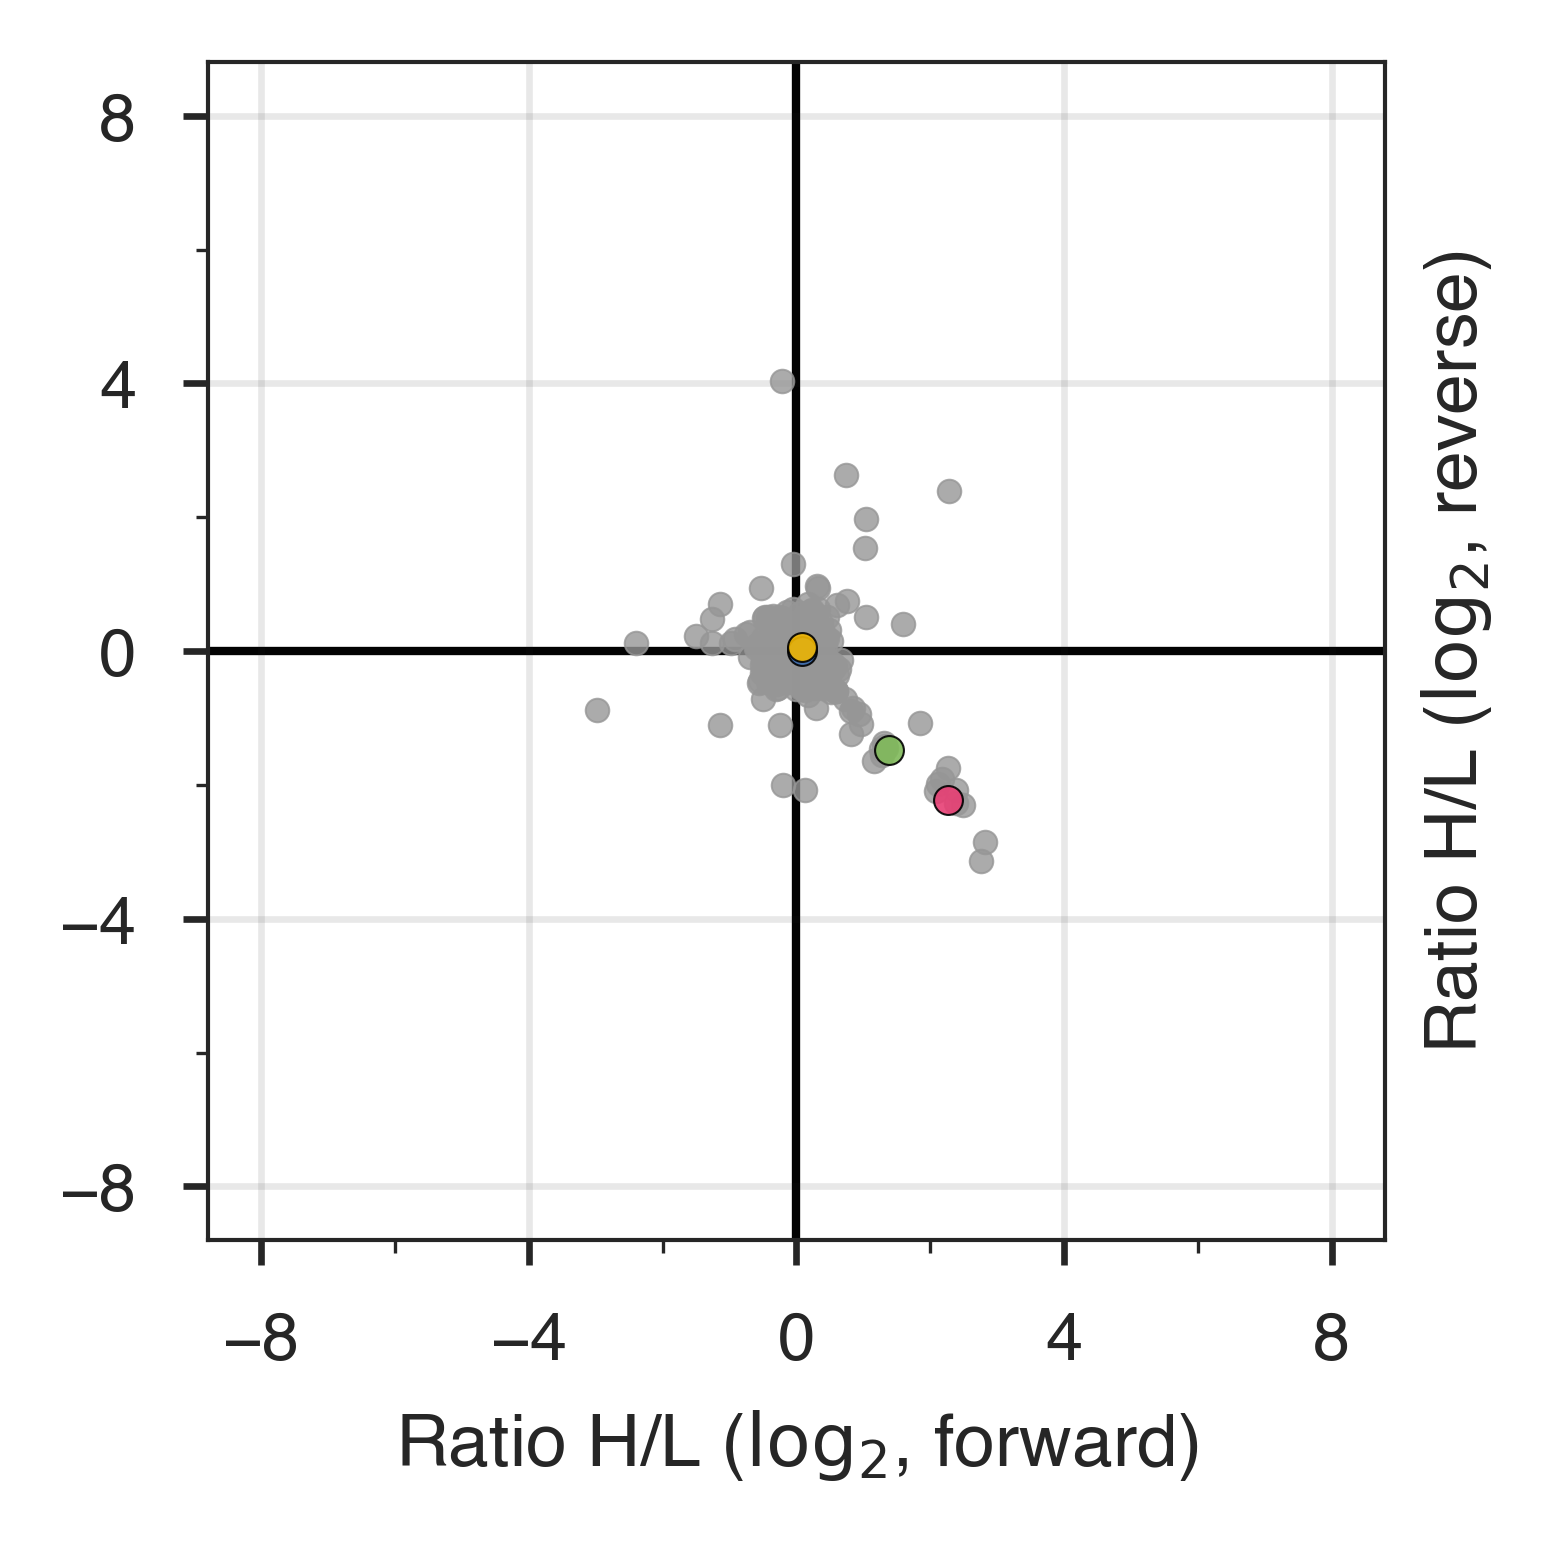

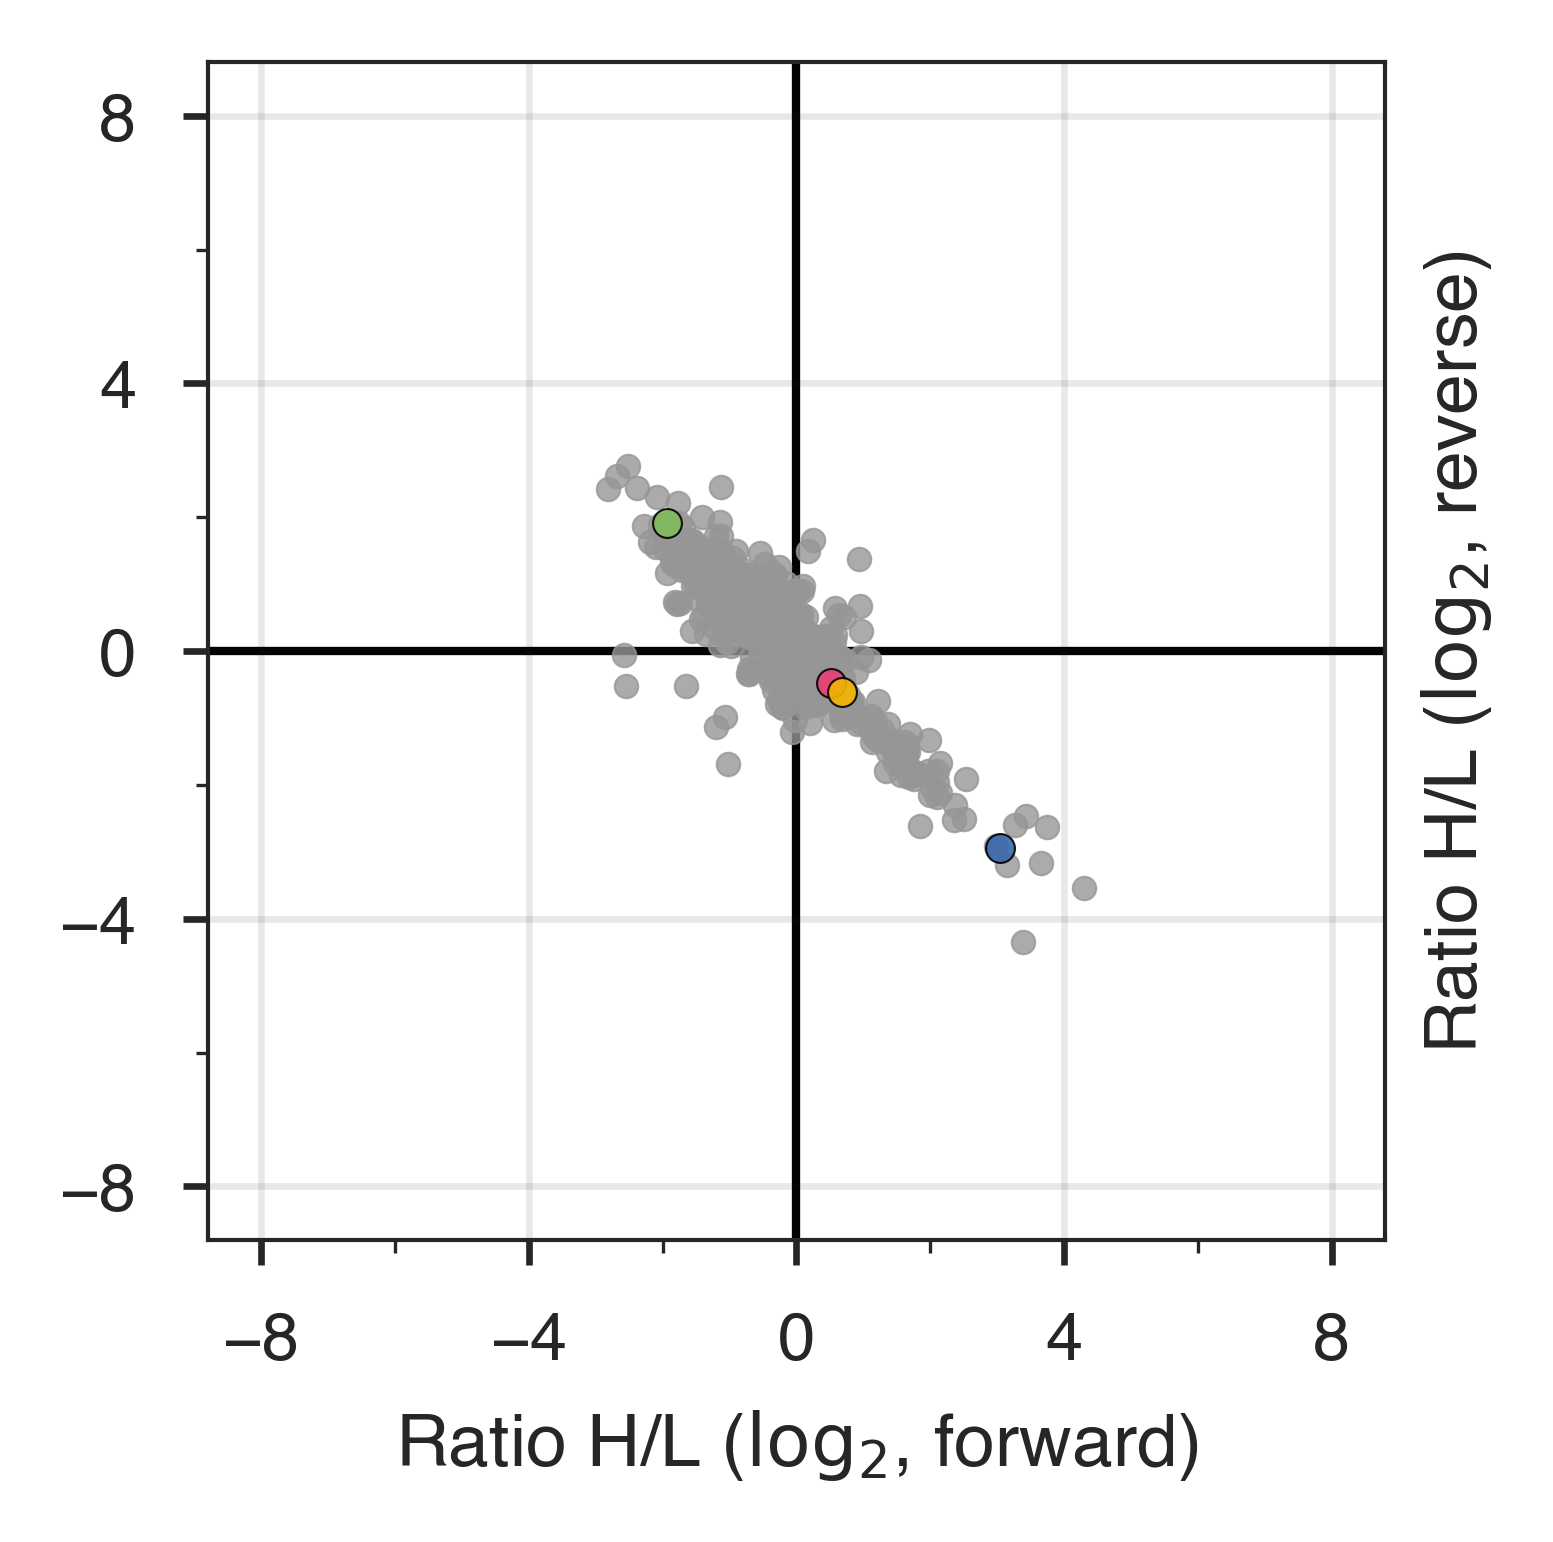

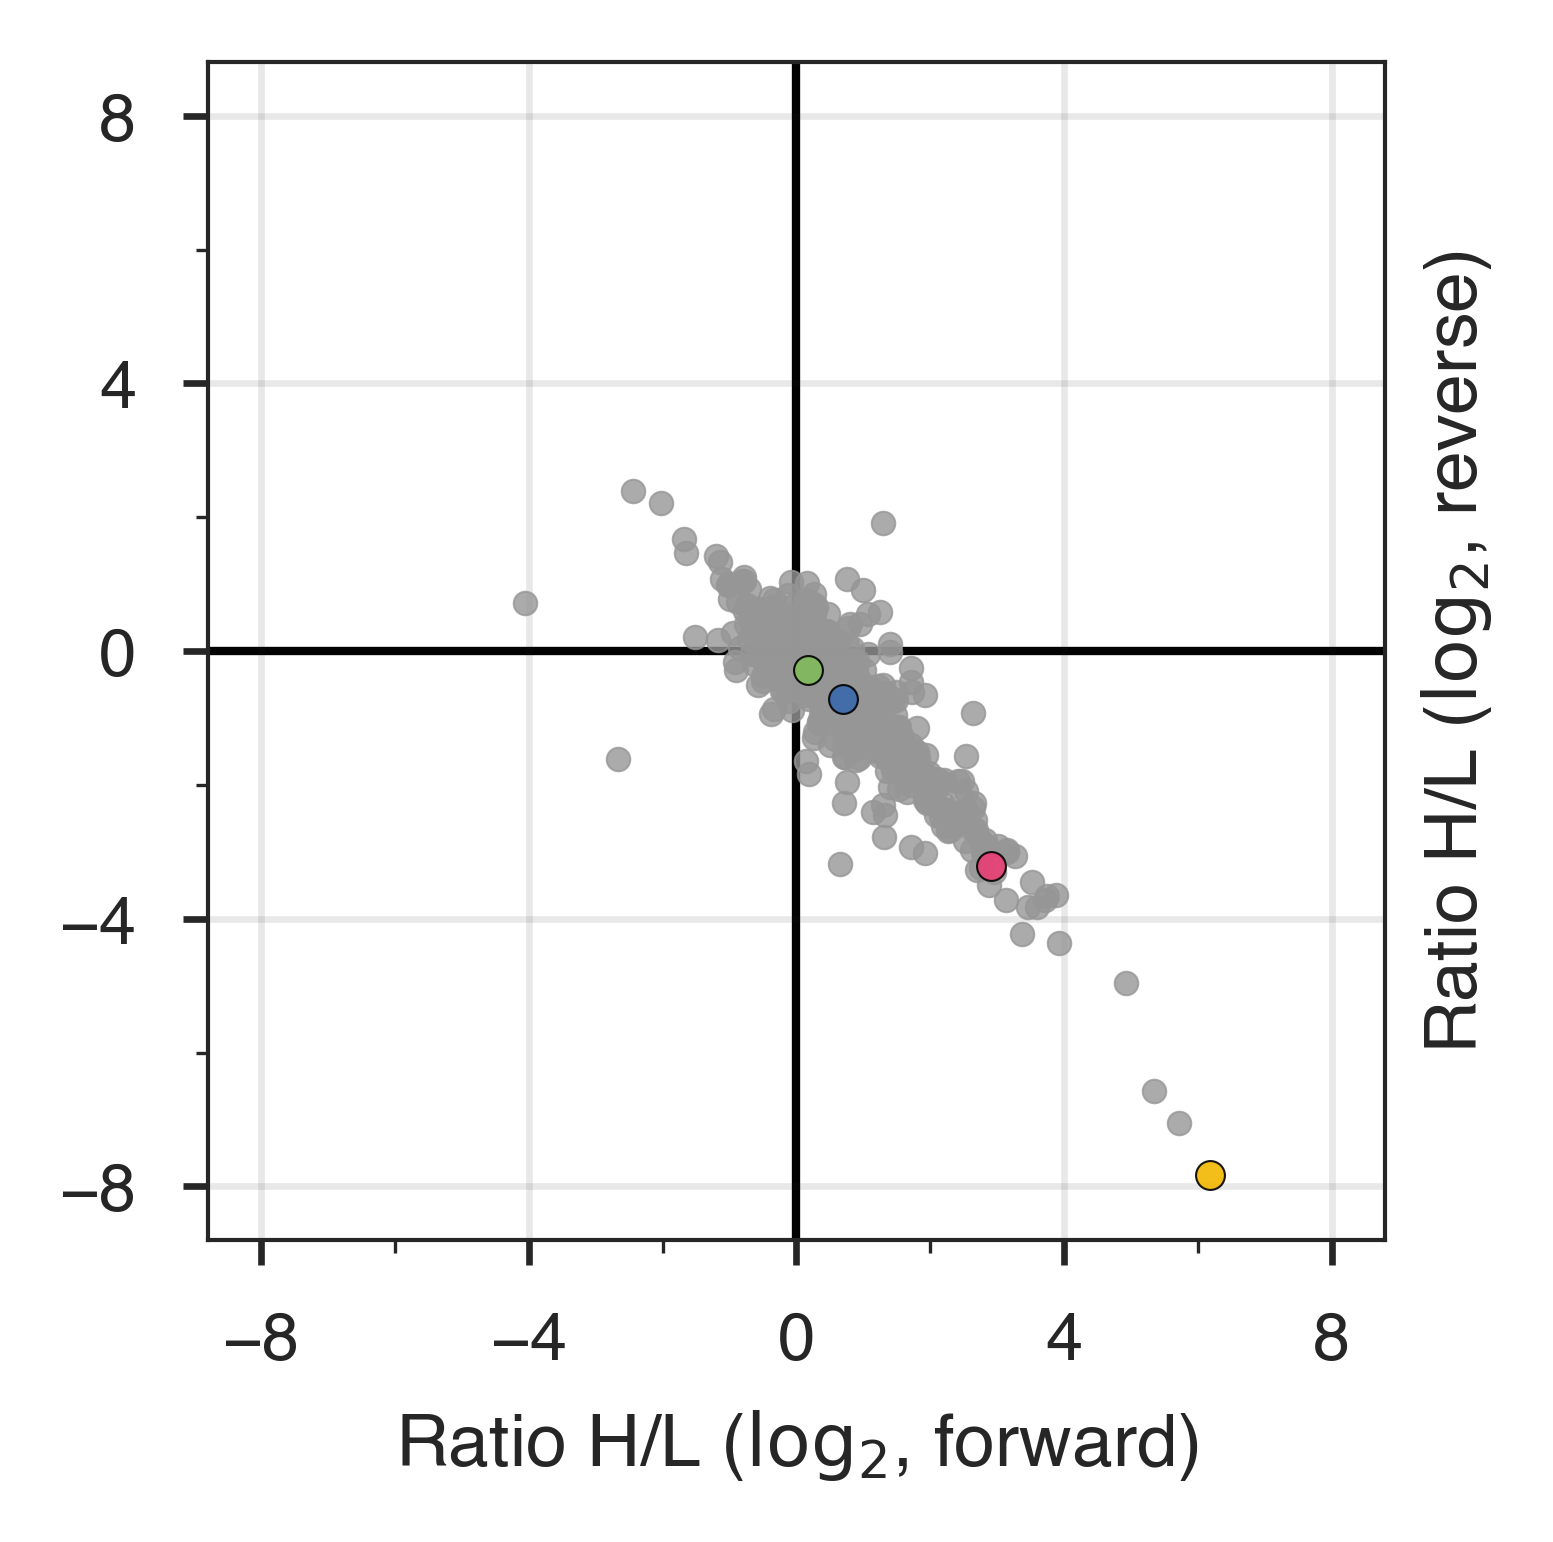

In [21]:
for pulldown in parameters.PDS_TO_HIGHLIGHT:

    subdata_with_imputed = data.loc(axis=0)[:, pulldown].dropna(subset=[COLUMN_X, COLUMN_Y])
    subdata = subdata_with_imputed[subdata_with_imputed['Imputation type'].isnull()]
    subdata = subdata.join(HIGHLIGHTS, on='Gene label')

    subdata_background = subdata[subdata['color'].isnull()]

    scatter_kws = dict()

    fig = plt.figure(figsize=(WIDTH, HEIGHT), dpi=300)
    ax = plt.gca()
    ax.axhline(0, color='k', linestyle='-', linewidth=1.0, zorder=0)
    ax.axvline(0, color='k', linestyle='-', linewidth=1.0, zorder=0)

    size_highlighted=12
    size_other=8

    ax.scatter(subdata_background[COLUMN_X], subdata_background[COLUMN_Y], 
               rasterized=True, color=COLOUR_BACKGROUND, alpha=.8, s=size_other,
               zorder=1, **scatter_kws)

    seen_colors = set([x[0] for x in subdata[~subdata['color'].isnull()].index])

    unseen_colors = set(HIGHLIGHTS.index) - seen_colors
    for unseen_protein in unseen_colors:
        color = HIGHLIGHTS[unseen_protein]
        ax.scatter(subdata_with_imputed.loc[(unseen_protein, pulldown), COLUMN_X], subdata_with_imputed.loc[(unseen_protein, pulldown), COLUMN_Y], 
                   linewidth=.25, edgecolor='black', linestyle='-', s=size_highlighted,
               color=color, alpha=.9,
               zorder=1, **scatter_kws)

    for color, colored_subdata in subdata[~subdata['color'].isnull()].groupby('color'):
        ax.scatter(colored_subdata[COLUMN_X], colored_subdata[COLUMN_Y], s=size_highlighted,
                   linewidth=.25, edgecolor='black',
               color=color, alpha=.9,
               zorder=1, **scatter_kws)

    xlim = ax.get_xlim()
    ylim = ax.get_ylim()

    xlim_absmax = np.max(np.abs(xlim))
    ylim_absmax = np.max(np.abs(ylim))

    xylim_absmax = parameters.LIMITS_INTEGER * 1.1

    ax.set_xlim(-xylim_absmax, xylim_absmax)
    ax.set_ylim(-xylim_absmax, xylim_absmax)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(parameters.MAJOR_TICKS))
    ax.xaxis.set_minor_locator(ticker.MultipleLocator(parameters.MINOR_TICKS))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(parameters.MAJOR_TICKS))
    ax.yaxis.set_minor_locator(ticker.MultipleLocator(parameters.MINOR_TICKS))
    ax.yaxis.set_label_position("right")

    ax.grid(True)
    ax.spines['top'].set_visible(True)
    ax.spines['right'].set_visible(True)
    ax.set_aspect('equal')

    ax.set_xlabel('Ratio H/L ($\log_2$, forward)')
    ax.set_ylabel('Ratio H/L ($\log_2$, reverse)')

    plt.savefig(os.path.join(OUTPUT_DIRECTORY, f'scatter-{pulldown}.pdf'), bbox_inches='tight')